## Exploring historical time series from weather baloons

In [1]:
import cartopy
import cartopy.crs as ccrs
import os
import shutil
import ftplib
import pandas as pd
import numpy as np
import zipfile
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib.backends.backend_pdf import PdfPages

## Weather balloon data are available at
`https://www1.ncdc.noaa.gov/pub/data`

Let's choose a couple interesting sites from `igra2-station-list.txt`

### We can read in the data frame taking advantage of `pandas` fixed-widthg reader

In [2]:
infile = os.path.join('weather','igra2-station-list.txt')

In [3]:
# we can specify either column widths......
alldat1 = pd.read_fwf(infile, widths=[12,9,10,7,3,30,5,5,7], 
          names=['station_id','lat','lon','elev','state','station_name','styear','endyear','nobs'],
                     sep=' ')
# .......or starting/ending column indices
alldat2= pd.read_fwf(infile, 
           colspecs=[(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,76),(77,81),(82,88)],
          names=['station_id','lat','lon','elev','state','station_name','styear','endyear','nobs'])
        

In [4]:
alldat1.loc[alldat1.station_name=='HACHIJOJIMA']

station_id      lat       lon   elev state station_name  styear  \
1127  JAM00047678  33.1217  139.7792  151.2   NaN  HACHIJOJIMA    1958   

      endyear   nobs  
1127     2017  60377

## We can plot a single location on a simple map

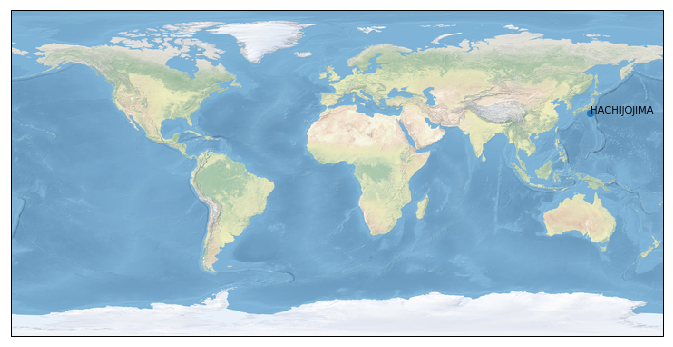

In [5]:
plt.figure(figsize=(12,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()
plt.plot(alldat1.loc[alldat1.station_name=='HACHIJOJIMA'].lon,
         alldat1.loc[alldat1.station_name=='HACHIJOJIMA'].lat,
        marker='o',linewidth=2)

plt.text(alldat1.loc[alldat1.station_name=='HACHIJOJIMA'].lon,
         alldat1.loc[alldat1.station_name=='HACHIJOJIMA'].lat,
        alldat1.loc[alldat1.station_name=='HACHIJOJIMA'].station_name.values[0])


# What about all points?

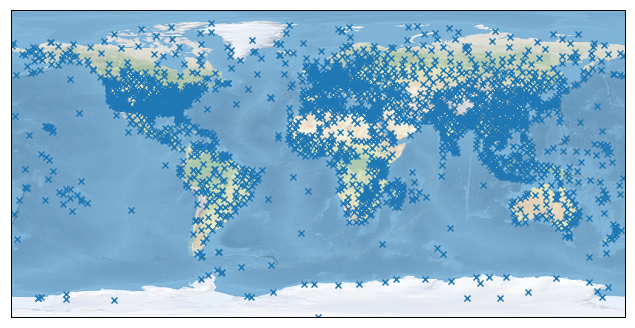

In [6]:
fig, ax = plt.subplots(figsize=(11, 8.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(alldat1.lon,alldat1.lat,marker='x',)
ax.stock_img()


## How about all points older than a certain year?

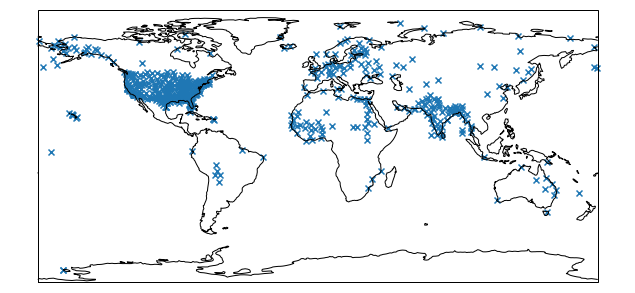

In [7]:
df = alldat1.loc[alldat1.styear<1945]
fig, ax = plt.subplots(figsize=(11, 8.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(df.lon,df.lat,marker='x',)
ax.coastlines();

## How about all locations in a country, zoomed on that country?

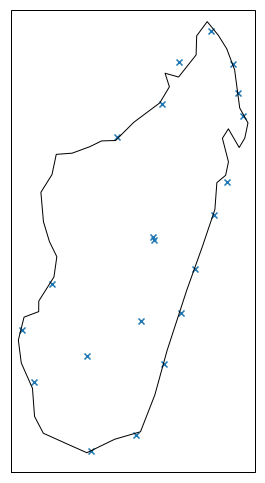

In [8]:
# JA is Japan, MA is Madagscar, 
df = alldat1.loc[[True if i.startswith('MA') else False for i in alldat1.station_id ]]
fig, ax = plt.subplots(figsize=(11, 8.5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.scatter(df.lon,df.lat,marker='x',)
ax.coastlines();

In [9]:
df

station_id      lat      lon    elev state         station_name  \
1266  MAM00067009 -12.3500  49.3000   114.0   NaN          ANTSIRANANA   
1267  MAM00067012 -13.3170  48.3170     9.0   NaN   FASCENE (NOSSI-BE)   
1268  MAM00067017 -13.3670  50.0000     5.0   NaN              VOHEMAR   
1269  MAM00067019 -14.6330  47.7670    57.0   NaN            ANALALAVA   
1270  MAM00067023 -14.2830  50.1670     5.0   NaN              SAMBAVA   
1271  MAM00067025 -15.0000  50.3330     6.0   NaN             ANTALAHA   
1272  MAM00067027 -15.6667  46.3500    26.0   NaN            MAHAJANGA   
1273  MAM00067072 -17.0830  49.8170     3.0   NaN  SAINTE-MARIE AERODR   
1274  MAM00067083 -18.8000  47.4833  1279.0   NaN   ANTANANARIVO/IVATO   
1275  MAM00067085 -18.9000  47.5333  1310.0   NaN       TANANARIVE/SCM   
1276  MAM00067095 -18.1167  49.4000     5.0   NaN            TOAMASINA   
1277  MAM00067113 -19.8330  48.8000     5.0   NaN             MAHANORO   
1278  MAM00067117 -20.2830  44.3170     7.0   NaN            MORONDAVA   
1279  MAM00067131 -21.7500  43.3670     4.0   NaN              MOROMBE   
1280  MAM00067137 -21.4500  47.1000  1115.0   NaN         FIANARANTSOA   
1281  MAM00067143 -21.2000  48.3670     5.0   NaN            MANANJARY   
1282  MAM00067152 -22.5500  45.4000   824.0   NaN             RANOHIRA   
1283  MAM00067157 -22.8000  47.8330     8.0   NaN          FARAFANGANA   
1284  MAM00067161 -23.3830  43.7330     8.0   NaN              TOLIARA   
1285  MAM00067194 -25.5500  45.5330    22.0   NaN             FAUX-CAP   
1286  MAM00067197 -25.0333  46.9500     8.0   NaN           TAOLAGNARO   

      styear  endyear   nobs  
1266    1973     2001   8157  
1267    1973     1981    786  
1268    1976     1981    807  
1269    1973     1980   1607  
1270    1973     1982   2763  
1271    1973     1999   4654  
1272    1973     2017  34091  
1273    1975     1981    681  
1274    1967     2017  32018  
1275    1952     1966   4211  
1276    1973     2017  18462  
1277    1975     1982   1069  
1278    1973     1997   3268  
1279    1977     1981   1328  
1280    1973     1994   1453  
1281    1973     1995   4840  
1282    1973     2017   1640  
1283    1973     1981   2385  
1284    1973     1996   5308  
1285    1973     1980    549  
1286    1972     2017  29095

# Now let's dig into the data

In [10]:
basedir = '/pub/data/igra/'

In [13]:
#station_id = 'JAM00047678'
#station_id = alldat1.loc[alldat1.station_name=='HACHIJOJIMA'].station_id.values[0]
station_id = alldat1.loc[alldat1.station_name=='ANTSIRANANA'].station_id.values[0]

urlfile = basedir+'derived/derived-por/{0}-drvd.txt.zip'.format(station_id)
dl_file = os.path.join('weather',os.path.split(urlfile)[-1])
if not os.path.exists(dl_file):
    ftp = ftplib.FTP('ftp.ncdc.noaa.gov')
    ftp.login()
    with open(dl_file, 'wb') as out_file:
        ftp.retrbinary('RETR {0}'.format(urlfile), out_file.write)

In [14]:
# now unzip the file
with zipfile.ZipFile(dl_file,"r") as zip_ref:
    zip_ref.extractall(os.path.join('weather','.'))

## What nice format is this file in?

In [15]:
indat = open(dl_file[:-4], 'r').readlines()

In [16]:
for i in range(20):
    print(indat[i])

#MAM00067009 1977 02 08 00 9999    7   4774-99999-99999-99999-99999-99999 55343  4944 98927    76 94948   432-99999-99999    -4     5    29    36-99999-99999

  99800     114     114    2976     -50    2977      48    3009    3011   29609   30695  -99999     965    -236      -3      19      -9      -7     385

  85000    1510    1495    2906     -45    3044      56    2922    3061   12657   19944  -99999     635      97      23       5     -19       1     283

  70000    3145    3140    2832     -52    3135      52    2847    3152    9777   12316  -99999     794     -37      31       0     -18       8     237

  50000    5880    5863    2689     -74    3278      28    2695    3285    3084    4458  -99999     692    -137      30      -1       5      -9     160

  40000    7610    7594    2561     -64    3327      45    2562    3330     734    1611  -99999     455     176      28      -8     -10      33     125

  30000    9720    9709    2427     -83    3423      20    2428    3425     

### let's find all the lines starting with `#`

In [17]:
hashlines = [i for i,j in enumerate(indat) if '#' in j]

In [18]:
headers = [indat[i] for i in hashlines]

### Make a class to store block information

In [19]:
class datblock(object):
    def __init__(self, ind, header, filename):
        if ind>0:
            self.stind = ind-1
        else:
            self.stind = ind
        header_split = header[:43].split() # just read the relevant part of the line
        self.date = dt.datetime(*[int(i) for i in header_split[1:5]])
        self.numlines = int(header_split[6])
        
        

### Parse all the headers

In [20]:
hashlines = np.array(hashlines)-np.array(range(len(hashlines))) + 1

In [21]:
parsed_headers = [datblock(cind,chead, dl_file[:-4]) for cind,chead in zip(hashlines,headers)]

In [22]:
df = pd.read_fwf(dl_file[:-4], 
          colspecs=[(0,1),(16,23),(24,31)],
          names=['junk','CALGPH','TEMP'],
          comment='#')
df.drop('junk',inplace=True, axis=1)

In [23]:
df.head()

CALGPH  TEMP
0     114  2976
1    1495  2906
2    3140  2832
3    5863  2689
4    7594  2561

### Now we can set up the date index

In [24]:
parsed_headers[2].__dict__

{'date': datetime.datetime(1977, 2, 11, 12, 0), 'numlines': 5, 'stind': 27}

In [25]:
dates = np.zeros(len(df),dtype=dt.datetime)
unique_dates = dates.copy()

In [26]:
for i in parsed_headers:
    dates[i.stind:i.stind+i.numlines] = i.date
    unique_dates[i.stind:i.stind+i.numlines] = '{0}_{1}'.format(i.date.day,i.date.hour)

In [27]:
df.index=dates
df['day_splitter'] = unique_dates

## Last data cleaning --> convert TEMP from K to degrees C (units are K * 10)

In [28]:
df.TEMP = df.TEMP/10-272.15

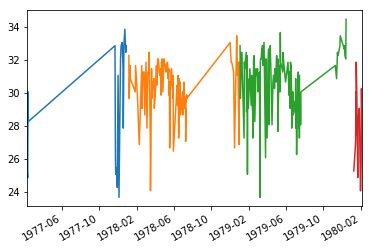

In [29]:
df.loc[df.CALGPH<200].resample('A').TEMP.plot();

In [30]:
with PdfPages('tmp_plot.pdf') as outpdf:
    for cn,cg in df.groupby(pd.TimeGrouper(freq='M')):
        if not cg.empty:
            if cg.index.year.values[0]==1980:
                plt.figure()
                for subn,subg in cg.groupby('day_splitter'):
                    plt.plot(subg.TEMP,subg.CALGPH)
                plt.title('{0} {1}'.format(cg.index.month.values[0],
                                          cg.index.year.values[0]))
                outpdf.savefig()
                plt.close()
